# Description

It summarizes the GLS results on PhenomeXcan, adjusting pvalues using FDR, and saving the final results to a pickle file for later use.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from phenoplier_plots import qqplot

# Settings

In [2]:
N_PHENOTYPES = 4091
N_LVS = 987

In [3]:
INPUT_DIR = conf.RESULTS["GLS"]
display(INPUT_DIR)
assert INPUT_DIR.exists()

INPUT_PATTERN = "phenomexcan_*/**/*.tsv.gz"
display(INPUT_PATTERN)

PosixPath('/opt/data/results/gls')

'phenomexcan_*/**/*.tsv.gz'

In [4]:
PVALUE_COLUMN = "pvalue"

In [5]:
OUTPUT_DIR = conf.RESULTS["GLS"]
display(OUTPUT_DIR)
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

PosixPath('/opt/data/results/gls')

# Load data

## Phenotype info

In [6]:
pheno_info = pd.read_csv(conf.PHENOMEXCAN["UNIFIED_PHENO_INFO_FILE"], sep="\t")

In [7]:
pheno_info.shape

(4091, 10)

In [8]:
pheno_info.head()

,pheno_id,full_code,short_code,description,unique_description,type,n,n_cases,n_controls,source
0,0,100001_raw-Food_weight,100001_raw,Food weight,Food weight,continuous_raw,51453,NaN,NaN,UK Biobank
1,1,100002_raw-Energy,100002_raw,Energy,Energy,continuous_raw,51453,NaN,NaN,UK Biobank
2,2,100003_raw-Protein,100003_raw,Protein,Protein,continuous_raw,51453,NaN,NaN,UK Biobank
3,3,100004_raw-Fat,100004_raw,Fat,Fat,continuous_raw,51453,NaN,NaN,UK Biobank
4,4,100005_raw-Carbohydrate,100005_raw,Carbohydrate,Carbohydrate,continuous_raw,51453,NaN,NaN,UK Biobank


In [9]:
assert pheno_info["short_code"].is_unique

In [10]:
pheno_code_to_desc_map = pheno_info.set_index("short_code")[
    "unique_description"
].to_dict()

## GLS results

### Get files list

In [11]:
INPUT_FILES = list(INPUT_DIR.glob(INPUT_PATTERN))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/phenomexcan_rapid_gwas/gls-gtex_v8_mashr-sub_corr/gls_phenoplier-AB1_OTHER_VIRAL.tsv.gz'),
 PosixPath('/opt/data/results/gls/phenomexcan_rapid_gwas/gls-gtex_v8_mashr-sub_corr/gls_phenoplier-20002_1134.tsv.gz'),
 PosixPath('/opt/data/results/gls/phenomexcan_rapid_gwas/gls-gtex_v8_mashr-sub_corr/gls_phenoplier-1747_4.tsv.gz'),
 PosixPath('/opt/data/results/gls/phenomexcan_rapid_gwas/gls-gtex_v8_mashr-sub_corr/gls_phenoplier-22617_1136.tsv.gz'),
 PosixPath('/opt/data/results/gls/phenomexcan_rapid_gwas/gls-gtex_v8_mashr-sub_corr/gls_phenoplier-M13_SHOULDER.tsv.gz')]

In [12]:
_tmp = len(INPUT_FILES)
display(_tmp)
assert _tmp == N_PHENOTYPES

4091

### Read results

In [13]:
INPUT_FILES[0].name.split("gls_phenoplier-")[1].split(".tsv.gz")[0]

'AB1_OTHER_VIRAL'

In [14]:
dfs = [
    pd.read_csv(f, sep="\t", usecols=["lv", "pvalue_onesided"]).assign(
        phenotype=f.name.split("gls_phenoplier-")[1].split(".tsv.gz")[0]
    )
    for f in INPUT_FILES
]

In [15]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

4091

In [16]:
dfs = pd.concat(dfs, axis=0, ignore_index=True).rename(
    columns={"pvalue_onesided": "pvalue"}
)

In [17]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(4037817, 3)

In [18]:
# add phenotype description
dfs = dfs.assign(
    phenotype_desc=dfs["phenotype"].apply(lambda x: pheno_code_to_desc_map[x])
)
dfs = dfs[["phenotype", "phenotype_desc", "lv", "pvalue"]]

In [19]:
dfs.head()

,phenotype,phenotype_desc,lv,pvalue
0,AB1_OTHER_VIRAL,Other viral diseases,LV736,0.004725
1,AB1_OTHER_VIRAL,Other viral diseases,LV320,0.004848
2,AB1_OTHER_VIRAL,Other viral diseases,LV366,0.005306
3,AB1_OTHER_VIRAL,Other viral diseases,LV964,0.006106
4,AB1_OTHER_VIRAL,Other viral diseases,LV92,0.006565


In [20]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

### FDR adjust

In [21]:
adj_pval = multipletests(dfs[PVALUE_COLUMN], alpha=0.05, method="fdr_bh")
dfs = dfs.assign(fdr=adj_pval[1])

In [22]:
dfs.shape

(4037817, 5)

In [23]:
dfs.head()

,phenotype,phenotype_desc,lv,pvalue,fdr
0,AB1_OTHER_VIRAL,Other viral diseases,LV736,0.004725,0.504339
1,AB1_OTHER_VIRAL,Other viral diseases,LV320,0.004848,0.508291
2,AB1_OTHER_VIRAL,Other viral diseases,LV366,0.005306,0.523691
3,AB1_OTHER_VIRAL,Other viral diseases,LV964,0.006106,0.548143
4,AB1_OTHER_VIRAL,Other viral diseases,LV92,0.006565,0.560048


# QQ-plot

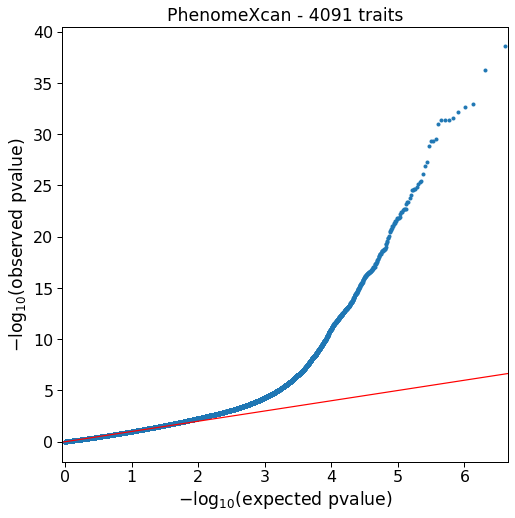

In [24]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(dfs["pvalue"])
    ax.set_title(f"PhenomeXcan - {N_PHENOTYPES} traits")

# Top hits

In [25]:
with pd.option_context("display.max_columns", None, "display.max_colwidth", None):
    _tmp = dfs.sort_values("fdr").drop(columns="phenotype")
    _tmp = _tmp[_tmp["fdr"] < 0.05]
    display(_tmp.head(50))

,phenotype_desc,lv,pvalue,fdr
3456474,Mean reticulocyte volume,LV30,2.705451e-39,1.092412e-32
1064973,Heel broadband ultrasound attenuation (right),LV874,5.970097e-37,1.205308e-30
3764418,Treatment/medication code: allopurinol (20003_1140875408),LV770,1.192106e-33,1.604502e-27
855729,"Non-cancer illness code, self-reported: gout",LV770,2.041706e-33,2.061009e-27
1367982,Heel broadband ultrasound attenuation (left),LV874,7.094100e-33,5.728935e-27
4036830,Triglycerides NMR,LV246,2.460305e-32,1.655710e-26
463890,"Heel quantitative ultrasound index (QUI), direct entry (right)",LV874,4.397697e-32,2.015331e-26
3587745,"Heel bone mineral density (BMD) T-score, automated (right)",LV874,4.401984e-32,2.015331e-26
2039142,Heel bone mineral density (BMD) (right),LV874,4.492026e-32,2.015331e-26
4024986,LDL Cholesterol NMR,LV246,9.696207e-32,3.915151e-26


## LV246

In [26]:
with pd.option_context("display.max_columns", None, "display.max_colwidth", None):
    _tmp = dfs[dfs["lv"] == "LV246"].sort_values("fdr").drop(columns="phenotype")
    _tmp = _tmp[_tmp["fdr"] < 0.05]
    display(_tmp.head(50))

,phenotype_desc,lv,pvalue,fdr
4036830,Triglycerides NMR,LV246,2.460305e-32,1.655710e-26
4024986,LDL Cholesterol NMR,LV246,9.696207e-32,3.915151e-26
1177491,"Non-cancer illness code, self-reported: high cholesterol",LV246,2.952274e-30,1.083704e-24
455007,"Medication for cholesterol, blood pressure, diabetes, or take exogenous hormones: Cholesterol lowering medication",LV246,1.483317e-29,4.278117e-24
378021,Treatment/medication code: simvastatin (20003_1140861958),LV246,1.711568e-24,2.559629e-19
4018077,CH2DB NMR,LV246,1.478299e-20,1.047211e-15
1303827,"Medication for cholesterol, blood pressure or diabetes: Cholesterol lowering medication",LV246,1.518204e-19,9.578481e-15
3591693,Treatment/medication code: atorvastatin (20003_1141146234),LV246,4.661357e-19,2.543474e-14
2109224,Illnesses of father: Alzheimer's disease/dementia,LV246,2.416461e-12,2.764086e-08
3931227,Illnesses of mother: Alzheimer's disease/dementia,LV246,2.414698e-12,2.764086e-08


# Optimize data types

In [27]:
dfs.head()

,phenotype,phenotype_desc,lv,pvalue,fdr
0,AB1_OTHER_VIRAL,Other viral diseases,LV736,0.004725,0.504339
1,AB1_OTHER_VIRAL,Other viral diseases,LV320,0.004848,0.508291
2,AB1_OTHER_VIRAL,Other viral diseases,LV366,0.005306,0.523691
3,AB1_OTHER_VIRAL,Other viral diseases,LV964,0.006106,0.548143
4,AB1_OTHER_VIRAL,Other viral diseases,LV92,0.006565,0.560048


In [28]:
dfs.memory_usage()

Index                  128
phenotype         32302536
phenotype_desc    32302536
lv                32302536
pvalue            32302536
fdr               32302536
dtype: int64

In [29]:
dfs["phenotype"] = dfs["phenotype"].astype("category")
dfs["phenotype_desc"] = dfs["phenotype_desc"].astype("category")
dfs["lv"] = dfs["lv"].astype("category")

In [30]:
dfs.head()

,phenotype,phenotype_desc,lv,pvalue,fdr
0,AB1_OTHER_VIRAL,Other viral diseases,LV736,0.004725,0.504339
1,AB1_OTHER_VIRAL,Other viral diseases,LV320,0.004848,0.508291
2,AB1_OTHER_VIRAL,Other viral diseases,LV366,0.005306,0.523691
3,AB1_OTHER_VIRAL,Other viral diseases,LV964,0.006106,0.548143
4,AB1_OTHER_VIRAL,Other viral diseases,LV92,0.006565,0.560048


In [31]:
dfs.memory_usage()

Index                  128
phenotype          8272202
phenotype_desc     8272202
lv                 8124490
pvalue            32302536
fdr               32302536
dtype: int64

# Save

In [32]:
output_file = OUTPUT_DIR / "gls-summary-phenomexcan.pkl.gz"
display(output_file)

PosixPath('/opt/data/results/gls/gls-summary-phenomexcan.pkl.gz')

In [33]:
dfs.to_pickle(output_file)